In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset

import numpy as np

import math

import time

import dataloader
import models
import training_fun

import optuna

import joblib

import HydroErr

In [23]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEQ_LENGTH = 365 * 2
TARGET_SEQ_LENGTH = 365
BASE_LENGTH = SEQ_LENGTH - TARGET_SEQ_LENGTH

FORCING_DIM = 3

N_CATCHMENTS = 559

# training hyperparameters
EPOCHS = 200
TRAIN_YEAR = 8
PATIENCE = 10

use_amp = True
compile_model = False

if compile_model:
    torch.set_float32_matmul_precision("high")

memory_saving = False
if memory_saving:
    storge_device = "cpu"
    computing_device = DEVICE
    VAL_STEPS = 500
else:
    storge_device = DEVICE
    computing_device = DEVICE

In [3]:
embedding = torch.load("data/final_lstm_embedding.pt", map_location=torch.device('cpu')).to(computing_device)
decoder = torch.load("data/final_lstm_decoder.pt", map_location=torch.device('cpu')).to(computing_device)

embedding.eval()
decoder.eval()

# dimension of embedding
catchment_embeddings=[x.data for x in embedding.parameters()][0]
LATENT_dim = catchment_embeddings.shape[1]

In [4]:
dtrain_val = dataloader.Forcing_Data(
    "data/camels_train_val.csv",
    record_length=3652,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

dtrain = dataloader.Forcing_Data(
    "data/camels_train.csv",
    record_length=2922,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

dval = dataloader.Forcing_Data(
    "data/camels_val.csv",
    record_length=1095,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

dtest = dataloader.Forcing_Data(
    "data/camels_test.csv",
    record_length=4383,
    storge_device=storge_device,
    seq_length=SEQ_LENGTH,
    target_seq_length=TARGET_SEQ_LENGTH,
    base_length=BASE_LENGTH,
)

# Start optimization

In [26]:
class FINE_TUNE_OBJECTIVE:
    def __init__(self, selected_catchment=0):
        self.selected_catchment = selected_catchment
        
    def fine_tune(self,trial):
       
        # define batch size
        batch_size_power = trial.suggest_int("batch_size_power", 4, 8)
        batch_size = 2**batch_size_power
       
        # define early stopper
        early_stopper = training_fun.EarlyStopper(patience=PATIENCE, min_delta=0)
        
        # load model
        decoder = torch.load("data/final_lstm_decoder.pt", map_location=torch.device('cpu')).to(computing_device)
        decoder = decoder.to(computing_device)
        
        # define new embeding for the selected catchment
        embedding = nn.Embedding(1, LATENT_dim).to(computing_device)
        embedding_input = torch.zeros(size = (batch_size,), dtype=torch.long, device=computing_device)

        # validation data
        x_val, y_val = dval.get_catchment_val_batch(self.selected_catchment)
        x_val, y_val = x_val.to(computing_device), y_val.to(computing_device)
        
        # define optimizers
        lr_embedding = trial.suggest_float("lr_embedding", 5e-5, 1e-2, log=True)
        embedding_optimizer = optim.Adam(embedding.parameters(), lr=lr_embedding)

        lr_decoder = trial.suggest_float("lr_decoder", 5e-5, 1e-2, log=True)
        decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr_decoder)
        
        # model training
        scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
        
        # steps per epoch
        steps = math.ceil(TRAIN_YEAR/batch_size)

        # train model
        for epoch in range(EPOCHS):

            # for each epoch get_random_batch method generates a batch that contains one year data for each catchment
            # repeat TRAIN_YEAR times to finish an epoch
            decoder.train()
            embedding.train()

            for step in range(steps):
                
                decoder_optimizer.zero_grad()
                embedding_optimizer.zero_grad()
                
                # put the models into training mode
                decoder.train()
                embedding.train()
                
                # get training batch and pass to device
                (x_batch, y_batch, _) = dtrain.get_catchment_random_batch(
                    selected_catchment=self.selected_catchment, batch_size=batch_size
                )
                
                x_batch, y_batch = (
                    x_batch.to(computing_device),
                    y_batch.to(computing_device),
                )
                
                # slice batch for training
                with torch.autocast(
                    device_type="cuda", dtype=torch.float16, enabled=use_amp
                ):
                    code = embedding(embedding_input)

                    # pass through decoder
                    out = decoder.decode(code, x_batch)

                    # compute loss
                    loss = training_fun.mse_loss_with_nans(out, y_batch)
                    
                scaler.scale(loss).backward()
                scaler.step(embedding_optimizer)
                scaler.step(decoder_optimizer)
                scaler.update()

            # validate model after each epochs
            decoder.eval()
            embedding.eval()
            
            with torch.autocast(
                device_type="cuda", dtype=torch.float16, enabled=use_amp
            ):
                with torch.no_grad():                    
                    code = embedding(torch.zeros(size = (x_val.shape[0],), dtype=torch.long, device=computing_device))
                    out = decoder.decode(code, x_val)
                    
                    val_loss = training_fun.mse_loss_with_nans(out, y_val).detach().cpu().numpy()
            
            # Handle pruning based on the intermediate value
            trial.report(val_loss, epoch)

            if trial.should_prune():
                torch.cuda.empty_cache()
                raise optuna.exceptions.TrialPruned()

            # Early stop using early_stopper, break for loop
            if early_stopper.early_stop(val_loss):
                break

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            
        return early_stopper.min_validation_loss

In [13]:
def get_optimal_steps(study):
    
    stats = study.best_trials[0].intermediate_values
    steps = max(stats, key=lambda k: stats[k]) + 1
    
    return steps

In [28]:
objective = FINE_TUNE_OBJECTIVE(selected_catchment=6)
study = optuna.create_study(study_name="fine_tune", direction="minimize", pruner=optuna.pruners.NopPruner())
study.optimize(objective.fine_tune, n_trials=30)

[I 2023-01-10 23:27:28,583] A new study created in memory with name: fine_tune
[I 2023-01-10 23:27:33,047] Trial 0 finished with value: 10.319487571716309 and parameters: {'batch_size_power': 5, 'lr_embedding': 0.00022797854570985666, 'lr_decoder': 0.0009569441704969781}. Best is trial 0 with value: 10.319487571716309.
[I 2023-01-10 23:27:47,452] Trial 1 finished with value: 14.827849388122559 and parameters: {'batch_size_power': 8, 'lr_embedding': 0.00037812613754686827, 'lr_decoder': 0.0002951810409059618}. Best is trial 0 with value: 10.319487571716309.
[I 2023-01-10 23:28:01,272] Trial 2 finished with value: 11.763388633728027 and parameters: {'batch_size_power': 8, 'lr_embedding': 0.003048830066343156, 'lr_decoder': 0.000955691099848598}. Best is trial 0 with value: 10.319487571716309.
[I 2023-01-10 23:28:03,771] Trial 3 finished with value: 15.577122688293457 and parameters: {'batch_size_power': 4, 'lr_embedding': 0.006258703311225808, 'lr_decoder': 0.0003473090014562868}. Best i

KeyboardInterrupt: 

In [14]:
class FINAL_MODEL_OBJECTIVE:
    def __init__(self, selected_catchment=0, val_metric=HydroErr.kge_2009, maximize = True):
        self.selected_catchment = selected_catchment
        self.val_metric = val_metric

    def test_final_model(self, study):
        STEP = get_optimal_steps(study)
        
        # optimal parameters
        lr_decoder = study.best_params["lr_decoder"]
        lr_embedding = study.best_params["lr_embedding"]
        batch_size_power = study.best_params["batch_size_power"]
        
        # load model
        embedding = torch.load("data/Caravan/embedding.pt", map_location=torch.device('cpu'))
        decoder = torch.load("data/Caravan/decoder.pt", map_location=torch.device('cpu'))
        embedding, decoder = embedding.to(DEVICE), decoder.to(DEVICE)
        
        # define new embedding for the selected catchment
        LATENT_DIM = embedding.weight.shape[1]
        embedding = nn.Embedding(1, LATENT_DIM).to(DEVICE)
        
        # define model optimizer
        decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr_decoder)
        embedding_optimizer = optim.Adam(embedding.parameters(), lr=lr_embedding)
        
        # loss function
        criterion = nn.MSELoss()

        # batch generator 
        x, y = train_val_batch_gen.dataset.x[self.selected_catchment,:,:], train_val_batch_gen.dataset.y[self.selected_catchment,:]
        catchment_train_batch_gen = Random_Batch_Generator(x, y)
        
        # testing data
        x_test, y_test = test_batch_gen.dataset.x[self.selected_catchment,:,:], test_batch_gen.dataset.y[self.selected_catchment,:]
        x_test, y_test = x_test.to(DEVICE), y_test.to(DEVICE)
        
        # define STEP number and batch size
        STEP = get_optimal_steps(study)
        
        BATCH_SIZE = 2 ** batch_size_power

        SUBSETP = round(2**8/BATCH_SIZE)
        
        # Train model
        # outer loop, each step trains on 2**8 years of data
        for step in range(STEP):
            # inner loop, each substep trains on BATCH_SIZE years of data
            for substep in range(SUBSETP):
                
                decoder.train()
                embedding.train()
                
                decoder_optimizer.zero_grad()
                embedding_optimizer.zero_grad()

                x_batch, y_batch = catchment_train_batch_gen.get_batch(BATCH_SIZE)
                x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)

                code = embedding.forward(torch.zeros([BATCH_SIZE]).long().to(DEVICE))

                preds = decoder.decode(code, x_batch)

                loss = criterion(preds[:,BASE_LENGTH:], y_batch[:,BASE_LENGTH:])

                loss.backward()
                embedding_optimizer.step()
                decoder_optimizer.step()
        
        pred = pred_hydrograph(x_test, embedding, decoder).cpu().detach().numpy()
        ob = y_test[BASE_LENGTH:].squeeze().cpu().detach().numpy()

        val_error = self.val_metric(simulated_array=pred, observed_array=ob)        
        
        return val_error

In [15]:
n_catchment = train_batch_gen.dataset.x.shape[0]

kges = np.zeros(n_catchment)

In [16]:
for i in range(n_catchment):

    objective = FINE_TUNE_OBJECTIVE(selected_catchment=6,val_metric=HydroErr.kge_2009)
    study = optuna.create_study(study_name="fine_tune", direction="maximize", pruner=optuna.pruners.NopPruner())
    study.optimize(objective.fine_tune, n_trials=30)
    
    final_model = FINAL_MODEL_OBJECTIVE(selected_catchment=6)
    kges[i] = final_model.test_final_model(study)

[I 2022-11-16 22:06:28,349] A new study created in memory with name: fine_tune
[I 2022-11-16 22:06:31,832] Trial 0 finished with value: 0.714173526861441 and parameters: {'lr_decoder': 0.004455242442628894, 'lr_embedding': 0.0028589522160209673, 'batch_size_power': 2}. Best is trial 0 with value: 0.714173526861441.
[I 2022-11-16 22:06:33,967] Trial 1 finished with value: 0.5561816615487771 and parameters: {'lr_decoder': 3.307752523027473e-05, 'lr_embedding': 0.005952159022018839, 'batch_size_power': 8}. Best is trial 0 with value: 0.714173526861441.
[I 2022-11-16 22:06:35,620] Trial 2 finished with value: 0.7237952390073575 and parameters: {'lr_decoder': 0.001410122299357495, 'lr_embedding': 0.004691866381637568, 'batch_size_power': 2}. Best is trial 2 with value: 0.7237952390073575.
[I 2022-11-16 22:06:43,901] Trial 3 finished with value: 0.6406846309970404 and parameters: {'lr_decoder': 1.1600406389220111e-05, 'lr_embedding': 0.007572416312343393, 'batch_size_power': 4}. Best is tria

In [17]:
final_model = FINAL_MODEL_OBJECTIVE(selected_catchment=6)
final_model.test_final_model(study)

0.7015790309230656

In [18]:
kges

array([0.73300632, 0.75700459, 0.75679047, 0.7853962 , 0.76679749,
       0.80043645, 0.7741301 , 0.77722311, 0.81351764, 0.77567302,
       0.76164549, 0.81445592, 0.79142317, 0.7926233 , 0.75481509,
       0.79281723, 0.78937493, 0.77685068, 0.75210628, 0.74610113,
       0.77285859, 0.77822913, 0.8064802 , 0.79189234, 0.69788854,
       0.78788675, 0.76456833, 0.76289219, 0.77257756, 0.793987  ,
       0.74054675, 0.78801975, 0.79460929, 0.78478895, 0.78880546,
       0.79823681, 0.79354327, 0.75687781, 0.77586485, 0.8008237 ,
       0.7984164 , 0.79065714, 0.64175463, 0.796974  , 0.79869622,
       0.79123079, 0.79599285, 0.80681803, 0.72845742, 0.78757984,
       0.79549725, 0.77760761, 0.77329793, 0.74662771, 0.75857447,
       0.79245536, 0.78311778, 0.79291637, 0.5953314 , 0.79257388,
       0.76828759, 0.77222999, 0.7595487 , 0.82005961, 0.77755234,
       0.76114327, 0.76864108, 0.79909192, 0.80346413, 0.77630285,
       0.7763291 , 0.77157044, 0.73742081, 0.80564131, 0.74544

In [19]:
kges.mean()

0.777026666193491

In [20]:
np.savetxt("data/ft_KGEs.csv", kges, delimiter=",")

In [19]:
study.best_params

{'lr_decoder': 0.0005163395431662908,
 'lr_embedding': 0.007596987669650682,
 'batch_size_power': 2}

In [22]:
selected_catchment = 4 

val_metric = HydroErr.rmse

PATIENCE = 3

# each step is about 17 pass of the training data set (256 years/17 years)
STEP = 1000

early_stopper = EarlyStopper(patience=PATIENCE, min_delta=0)

load model

In [13]:
embedding = torch.load("data/Caravan/embedding.pt", map_location=torch.device('cpu'))
decoder = torch.load("data/Caravan/decoder.pt", map_location=torch.device('cpu'))

# derive dimension of latent space
embedding, decoder = embedding.to(DEVICE), decoder.to(DEVICE)

defined new model

In [14]:
LATENT_DIM = embedding.weight.shape[1]

# loss function
criterion = nn.MSELoss()

# define new embeding for the selected catchment
embedding = nn.Embedding(1, LATENT_DIM).to(DEVICE)

define batch generator for model training, and get validation dataset.

In [65]:
# batch generator
x, y = train_batch_gen.dataset.x[selected_catchment,:,:], train_batch_gen.dataset.y[selected_catchment,:]
catchment_train_batch_gen = Random_Batch_Generator(x, y)

x_val, y_val = val_batch_gen.dataset.x[selected_catchment,:,:], val_batch_gen.dataset.y[selected_catchment,:]
x_val, y_val = x_val.to(DEVICE), y_val.to(DEVICE)

define train optimizer

In [17]:
lr_decoder = trial.suggest_float("lr_decoder", 1e-5, 1e-2, log=True)
lr_embedding = trial.suggest_float("lr_embedding", 1e-5, 1e-2, log=True)

decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr_decoder)
embedding_optimizer = optim.Adam(embedding.parameters(), lr=lr_embedding)

model training

In [75]:
# define batch size
batch_size_power = trial.suggest_int("batch_size_power", 1, 8)
BATCH_SIZE = 2 ** batch_size_power

SUBSETP = round(2**8/BATCH_SIZE)

for step in range(STEP):
    
    for substep in range(SUBSETP):

        decoder_optimizer.zero_grad()
        embedding_optimizer.zero_grad()

        x_batch, y_batch = catchment_train_batch_gen.get_batch()
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)

        code = embedding.forward(torch.zeros([BATCH_SIZE]).long())

        preds = decoder.decode(code, x_batch)

        loss = criterion(preds[:,BASE_LENGTH:], y_batch[:,BASE_LENGTH:])

        loss.backward()
        embedding_optimizer.step()
        decoder_optimizer.step()
        
    # validate model
    pred = pred_hydrograph(x_val, embedding, decoder).cpu().detach().numpy()
    ob = y_val[BASE_LENGTH:].squeeze().cpu().detach().numpy()

    val_error = val_metric(simulated_array=pred, observed_array=ob)
    
    trial.report(val_error, step)

    # Handle pruning based on the intermediate value.
    if trial.should_prune():
        torch.cuda.empty_cache()
        raise optuna.exceptions.TrialPruned()
    
    # Early stop using early_stopper, break for loop
    if early_stopper.early_stop(val_error):
        break
    
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    
early_stopper.min_validation_loss

validate model

In [77]:
pred = pred_hydrograph(x_val, embedding, decoder).cpu().detach().numpy()
ob = y_val[BASE_LENGTH:].squeeze().cpu().detach().numpy()

HydroErr.kge_2009(simulated_array=pred, observed_array=ob)

(torch.Size([2191, 3]), torch.Size([2191]))

In [95]:
class FN:
    def __init__(self, x, y, eval_fun):
        self.eval_fun = eval_fun
        self.x = x
        self.y = y
    
    def eval(self, code, return_simulation = False):
        
        # numpy to torch tensor
        code = torch.from_numpy(code).unsqueeze(0).to(dtype=torch.float32).to(DEVICE)
        
        # BASE_LENGTH is from global
        pred = pred_hydrograph(code,self.x).cpu().detach().numpy()
        ob = self.y[:,BASE_LENGTH:].squeeze().cpu().detach().numpy()
        
        if return_simulation:
             return pred, ob
        else:
            return self.eval_fun(simulated_array=pred, observed_array=ob)

In [18]:
num_generations = 100
num_parents_mating = 4

sol_per_pop = 20
num_genes = 4

init_range_low = -5
init_range_high = 5

parent_selection_type = "sss"

crossover_type = "single_point"

mutation_type = "random"
mutation_probability = 0.25




In [ ]:
def evaluate_calibration(selected_catchment=[0]):
    
    batch_gen = train_val_batch_gen

    x = batch_gen.dataset.x[selected_catchment]
    y = batch_gen.dataset.y[selected_catchment]

    x, y = x.to(DEVICE), y.to(DEVICE)
    
    fn = FN(x,y,HydroErr.kge_2009)

    def fitness_func(solution, solution_idx):
        return fn.eval(solution)

    ga_instance = pygad.GA(num_generations=num_generations,
                        num_parents_mating=num_parents_mating,
                        fitness_func=fitness_func,
                        sol_per_pop=sol_per_pop,
                        num_genes=num_genes,
                        init_range_low=init_range_low,
                        init_range_high=init_range_high,
                        parent_selection_type=parent_selection_type,
                        crossover_type=crossover_type,
                        mutation_type=mutation_type,
                        mutation_probability = mutation_probability)
    
    ga_instance.run()
    
    solution, solution_fitness, solution_idx = ga_instance.best_solution()
    
    # evaluate on test dataset
    batch_gen = test_batch_gen

    x = batch_gen.dataset.x[selected_catchment]
    y = batch_gen.dataset.y[selected_catchment]

    x, y = x.to(DEVICE), y.to(DEVICE)

    fn = FN(x,y,HydroErr.kge_2009)

    return fn.eval(solution)


In [19]:
N_CATCHMENT = train_val_batch_gen.dataset.x.shape[0]

calibrated_KGES = np.ones(N_CATCHMENT)

for i in range(N_CATCHMENT):
    calibrated_KGES[i] = evaluate_calibration([i])

In [20]:
calibrated_KGES

array([ 0.83700747,  0.83620823,  0.80797727,  0.79082632,  0.55603452,
        0.76387255,  0.83675346,  0.79412707,  0.78606325,  0.80787591,
        0.71579784,  0.78936212,  0.69263578,  0.6828515 ,  0.58884901,
        0.66550234,  0.4944344 ,  0.66136467,  0.66563508,  0.55913044,
        0.65621905,  0.60670908,  0.56137239,  0.56448791,  0.6761262 ,
        0.64380265,  0.68119387,  0.40715628,  0.58130254,  0.44619568,
        0.64195739,  0.76333229,  0.74881338,  0.68809094,  0.48371633,
        0.76286619,  0.63840102,  0.6269843 ,  0.6408594 ,  0.6105041 ,
        0.53615003,  0.48180234,  0.69019234,  0.63205952,  0.59650706,
        0.5319386 ,  0.37973857,  0.58214076,  0.39334568,  0.52213128,
        0.36084932,  0.62301604,  0.6672367 ,  0.57084569,  0.5798021 ,
        0.60509403,  0.52508987,  0.51538886,  0.59598407,  0.58085401,
        0.51298058,  0.55154698,  0.53790912,  0.68569176,  0.5969475 ,
        0.35042831,  0.50588604,  0.48838279,  0.5689235 ,  0.56

In [23]:
calibrated_KGES.max()

0.9226957830891651

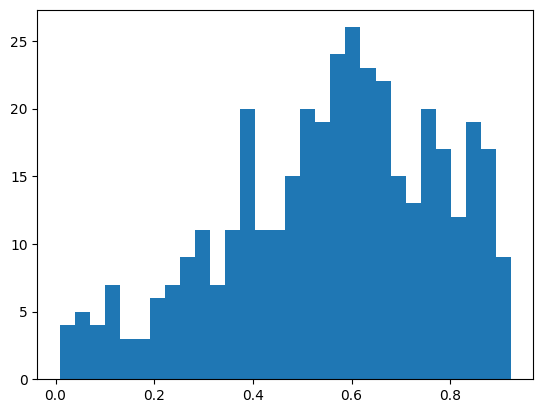

In [24]:
plt.hist(calibrated_KGES[calibrated_KGES>0], bins = 30)
plt.show()

In [24]:
N_CATCHMENT = train_val_batch_gen.dataset.x.shape[0]
calibrated_KGES = np.ones(N_CATCHMENT)
i = 0
calibrated_KGES[i] = evaluate_calibration([i])

In [47]:

selected_catchment = [110]

batch_gen = train_val_batch_gen

x = batch_gen.dataset.x[selected_catchment]
y = batch_gen.dataset.y[selected_catchment]

x, y = x.to(DEVICE), y.to(DEVICE)

In [50]:
fn = FN(x,y,HydroErr.kge_2009)

def fitness_func(solution, solution_idx):
    return fn.eval(solution)

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_func,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_probability = mutation_probability)

In [52]:
ga_instance.run()

In [53]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

Parameters of the best solution : [ 2.39297483 -3.06968491 -2.88818786 -2.89980175]
Fitness value of the best solution = 0.5666582062553918


In [54]:
batch_gen = test_batch_gen

x = batch_gen.dataset.x[selected_catchment]
y = batch_gen.dataset.y[selected_catchment]

x, y = x.to(DEVICE), y.to(DEVICE)

fn = FN(x,y,HydroErr.kge_2009)

fn.eval(solution)

0.6630948503353136

In [126]:
scaler = 1.25

UB, _ = torch.max(
    embedding.weight,
    0,
)

LB, _ = torch.min(
    embedding.weight,
    0,
)

UB = UB + torch.abs(UB)*(scaler - 1)
LB = LB - torch.abs(LB)*(scaler - 1)

UB = UB.cpu().detach().numpy()
LB = LB.cpu().detach().numpy()

In [ ]:
x, y = train_val_batch_gen.dataset.x[1,:,:], train_val_batch_gen.dataset.y[1,:]
batch_size=64 
seq_length=730
x.shape, y.shape

record_length = y.shape[0]

selected_starting_index = np.random.choice(    
    record_length - seq_length + 1, size=batch_size, replace=True
)

selected_ending_index = selected_starting_index + seq_length

xs_batch = torch.ones([batch_size, seq_length, 3])
ys_batch = torch.ones([batch_size, seq_length])

i = 0

s_ind = selected_starting_index[i]
e_ind = selected_ending_index[i]

xs_batch[i,:,:] = x[s_ind:e_ind, :]
ys_batch[i,:] = y[s_ind:e_ind]
